# HFF Water Quality

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

In [2]:
def display_df(dftest):
    '''
    Display the output from a Dickey-Fuller test in a more readable format
    '''
    
    
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    display(dfoutput)

Notes from Senior Scientist, Rob Van Kirk:

Looks like two daily time series files are all you will need, once you put the water quality 15-minute data into daily time series format. Those two files are attached. The hydrology file is "IslandPark.TS.csv". The relevant columns for you are:
 
smoothed.elev           End-of-day (midnight) elevation in acre-feet--but maybe the next variable is better (thinking on the fly)

surfacearea.acres      End-of-day surface area of the reservoir in acres (subtract this from 8000 and you will get acres of exposed reservoir bottom--just thought of that)

delta.V.af                    Daily change in reservoir volume (acre-feet). If positive, reservoir is filling; if negative it's drafting

regQ.cfs                     Average daily reservoir outflow (cfs)

smoothed.nat.Q.cfs   Natural streamflow at the dam (cfs). This is not exactly the same as inflow, but it's close and is the streamflow that would be in the river in absence of Island Park Dam and Henry's Lake Dam. The storage/delivery at Henry's Lake is why this isn't exactly the same as inflow to Island Park, but this does represent natural watershed runoff. The effect of storage/delivery at Henry's Lake is small compared to the natural watershed processes. 


The climate data are in Clean.Climate.TS.csv. The attached text file gives you a guide to the column names, although the file itself is specific to the water-year format files. The three relevant stations are:


CC     Crab Creek SnoTel station, which is an indicator of conditions in tributaries that feed the west end of IP Reservoir

IP       Island Park SnoTel station, located one-half mile from the dam.

WE    White Elephant SnoTel station, located on the side of Mt. Sawtelle. It indicates conditions in the Henry's Lake/Mack's Inn area.



Summary:

Response variable is turbidity at our IPE water quality station.

Potential predictors/correlates:


Precipitation and snowmelt at the SnoTel stations

Turbidity at FR (Flat Rock) water quality station

chlorophyll and cyanobacteria indices at IPE (can't remember the column names right offhand; should be apparent)

Reservoir elevation

Exposed reservoir shoreline area (8000 - surface area)

Reservoir outflow

Natural flow at IP

In [3]:
ipe_df = pd.read_csv('data/15_min_data_HFF/IPE 15 min 2022-08-08.csv')
ipe_df

,contTime,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
0,2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285217,2022-08-07 23:00:00,5.48,NaN,NaN,0.34,NaN,0.02,NaN,7.49,NaN,...,18.66,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285218,2022-08-07 23:15:00,5.74,NaN,NaN,0.27,NaN,0.03,NaN,7.48,NaN,...,18.64,123.5,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285219,2022-08-07 23:30:00,6.37,NaN,NaN,0.29,NaN,0.03,NaN,7.47,NaN,...,18.64,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285220,2022-08-07 23:45:00,6.40,NaN,NaN,0.34,NaN,0.02,NaN,7.48,NaN,...,18.63,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ipe_df['contTime'] = pd.to_datetime(ipe_df['contTime'])
ipe_df.set_index(['contTime'], inplace=True)
ipe_df.index.names = ['date']
ipe_df

,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,Temp_C,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
date,,,,,,,,,,,,,,,,,,,,,
2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-07 23:00:00,5.48,NaN,NaN,0.34,NaN,0.02,NaN,7.49,NaN,18.66,...,18.66,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-07 23:15:00,5.74,NaN,NaN,0.27,NaN,0.03,NaN,7.48,NaN,18.64,...,18.64,123.5,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-07 23:30:00,6.37,NaN,NaN,0.29,NaN,0.03,NaN,7.47,NaN,18.64,...,18.64,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
ipe_daily = ipe_df.resample('D').mean()

In [6]:
ipe_daily = ipe_daily[:'2022-08-01']

In [7]:
ipe_daily

,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,Temp_C,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
date,,,,,,,,,,,,,,,,,,,,,
2014-06-20,2.282571,NaN,2.883333,0.343889,NaN,-0.009167,NaN,6.402500,NaN,13.020333,...,13.020333,98.772222,83.000000,11.642306,2.948023,0.603837,0.102474,13.602552,7.434667,119.362484
2014-06-21,2.491979,2.487097,NaN,0.366667,0.367527,-0.003125,-0.002581,6.491563,6.511828,12.617740,...,12.617740,97.936458,83.302083,11.666146,3.087716,0.643661,0.112450,13.759623,7.438532,119.774590
2014-06-22,2.760521,2.760521,NaN,0.370417,0.370417,-0.002396,-0.002396,6.799479,6.799479,12.587917,...,12.587917,98.336458,83.875000,11.690604,3.302915,0.710180,0.154355,13.946474,7.471170,120.355465
2014-06-23,3.366875,3.366875,4.056667,0.427187,0.427187,0.011667,0.011667,6.973333,6.973333,12.869354,...,12.869354,100.618750,85.187500,11.717281,3.678330,0.552335,0.076311,13.898306,7.783264,119.795716
2014-06-24,4.185000,4.185000,NaN,0.578438,0.578438,0.051042,0.051042,6.847812,6.847812,12.998385,...,12.998385,104.945833,88.541667,11.707031,3.881812,0.502070,0.072871,14.001303,7.923084,121.559347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28,4.219896,4.219896,NaN,0.428229,0.428229,0.047188,0.047188,6.822292,6.822292,19.556458,...,19.556458,156.690625,0.110000,13.335000,3.351399,0.329851,0.105151,18.231818,6.663407,147.675620
2022-07-29,3.899583,3.899583,NaN,0.438333,0.438333,0.048646,0.048646,6.774479,6.774479,19.535104,...,19.535104,157.709375,0.110000,13.340729,3.625946,0.314202,0.068919,18.155853,6.629087,147.180402
2022-07-30,3.379583,3.379583,NaN,0.413229,0.413229,0.047708,0.047708,6.654688,6.654687,19.576562,...,19.576562,158.085417,0.110000,13.353229,3.899483,0.320148,0.051110,18.024200,6.586092,146.751797


<AxesSubplot:xlabel='date'>

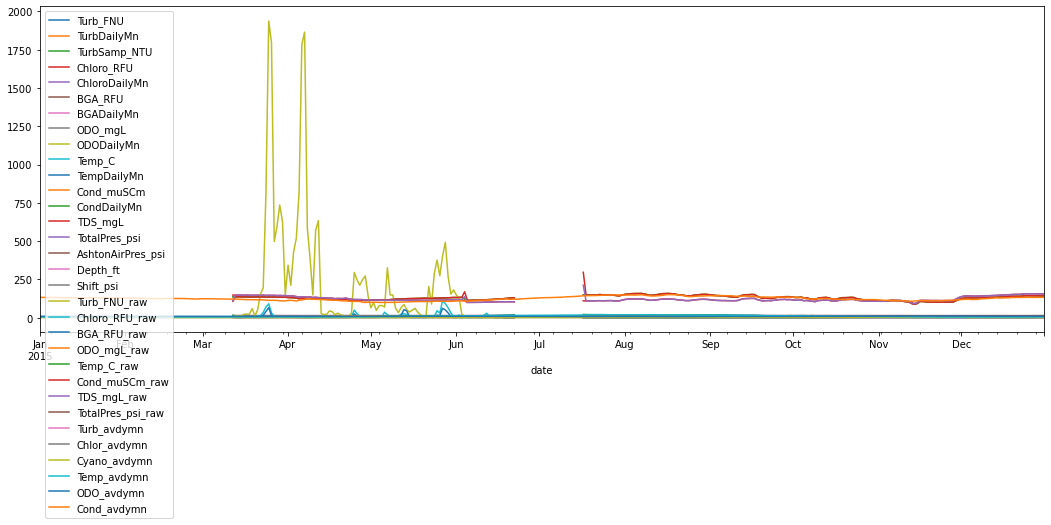

In [8]:
ipe_daily.loc['2015'].plot(figsize=(18,6))

In [9]:
ipe_daily.isna().sum()

Turb_FNU              348
TurbDailyMn           349
TurbSamp_NTU         2670
Chloro_RFU            355
ChloroDailyMn         356
BGA_RFU               353
BGADailyMn            354
ODO_mgL               193
ODODailyMn            194
Temp_C                191
TempDailyMn           192
Cond_muSCm            191
CondDailyMn           192
TDS_mgL               191
TotalPres_psi         191
AshtonAirPres_psi    1697
Depth_ft             1742
Shift_psi             161
Turb_FNU_raw          191
Chloro_RFU_raw        191
BGA_RFU_raw           191
ODO_mgL_raw           191
Temp_C_raw            191
Cond_muSCm_raw        191
TDS_mgL_raw           191
TotalPres_psi_raw     191
Turb_avdymn             0
Chlor_avdymn            0
Cyano_avdymn            0
Temp_avdymn             0
ODO_avdymn              0
Cond_avdymn             0
dtype: int64

In [10]:
ipe_daily.columns

Index(['Turb_FNU', 'TurbDailyMn', 'TurbSamp_NTU', 'Chloro_RFU',
       'ChloroDailyMn', 'BGA_RFU', 'BGADailyMn', 'ODO_mgL', 'ODODailyMn',
       'Temp_C', 'TempDailyMn', 'Cond_muSCm', 'CondDailyMn', 'TDS_mgL',
       'TotalPres_psi', 'AshtonAirPres_psi', 'Depth_ft', 'Shift_psi',
       'Turb_FNU_raw', 'Chloro_RFU_raw', 'BGA_RFU_raw', 'ODO_mgL_raw',
       'Temp_C_raw', 'Cond_muSCm_raw', 'TDS_mgL_raw', 'TotalPres_psi_raw',
       'Turb_avdymn', 'Chlor_avdymn', 'Cyano_avdymn', 'Temp_avdymn',
       'ODO_avdymn', 'Cond_avdymn'],
      dtype='object')

In [11]:
ipe_daily.drop(['TotalPres_psi', 'Turb_FNU', 'TurbDailyMn', 'TurbSamp_NTU', 'Chloro_RFU',
       'ChloroDailyMn', 'BGA_RFU', 'BGADailyMn', 'ODO_mgL', 'ODODailyMn',
       'Temp_C', 'TempDailyMn', 'Cond_muSCm', 'CondDailyMn', 'TDS_mgL', 'TotalPres_psi_raw',
       'Turb_avdymn', 'Chlor_avdymn', 'Cyano_avdymn', 'Temp_avdymn', 'Shift_psi',
       'ODO_avdymn', 'Cond_avdymn', 'AshtonAirPres_psi', 'Depth_ft'], axis=1, inplace=True)

In [12]:
ipe_interp = ipe_daily.interpolate(method='spline', order=2)

In [13]:
ipe_interp.columns

Index(['Turb_FNU_raw', 'Chloro_RFU_raw', 'BGA_RFU_raw', 'ODO_mgL_raw',
       'Temp_C_raw', 'Cond_muSCm_raw', 'TDS_mgL_raw'],
      dtype='object')

In [14]:
ipe_interp.isna().sum()

Turb_FNU_raw      0
Chloro_RFU_raw    0
BGA_RFU_raw       0
ODO_mgL_raw       0
Temp_C_raw        0
Cond_muSCm_raw    0
TDS_mgL_raw       0
dtype: int64

In [15]:
ipe_interp.dropna(inplace=True)

<AxesSubplot:xlabel='date'>

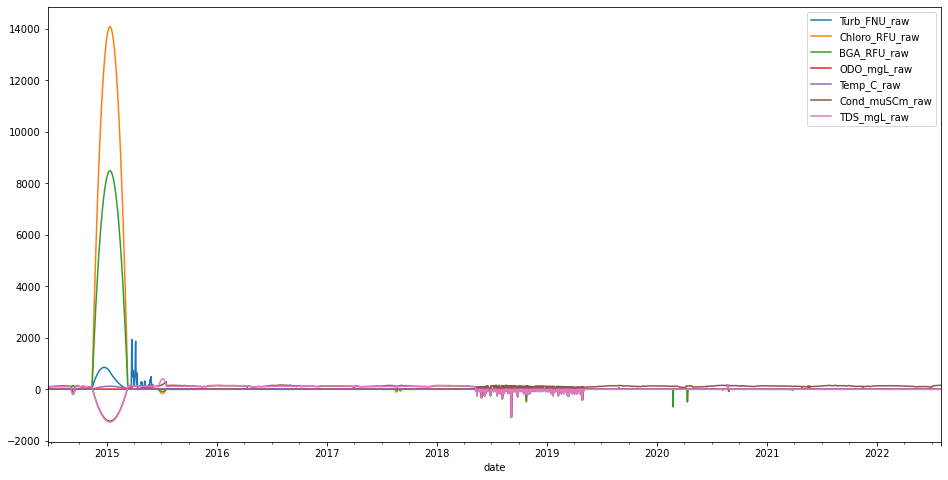

In [16]:
ipe_interp.plot(figsize=(16,8))

In [17]:
ipe_interp.corr()

,Turb_FNU_raw,Chloro_RFU_raw,BGA_RFU_raw,ODO_mgL_raw,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw
Turb_FNU_raw,1.000000,0.705183,0.707896,0.287114,0.529890,-0.629231,-0.562999
Chloro_RFU_raw,0.705183,1.000000,0.999905,0.045545,0.436295,-0.970711,-0.916569
BGA_RFU_raw,0.707896,0.999905,1.000000,0.057370,0.446889,-0.968211,-0.913528
ODO_mgL_raw,0.287114,0.045545,0.057370,1.000000,0.905702,0.162612,0.203583
Temp_C_raw,0.529890,0.436295,0.446889,0.905702,1.000000,-0.233900,-0.181156
Cond_muSCm_raw,-0.629231,-0.970711,-0.968211,0.162612,-0.233900,1.000000,0.952351
TDS_mgL_raw,-0.562999,-0.916569,-0.913528,0.203583,-0.181156,0.952351,1.000000


In [63]:
# import island park dam hydrology data
hydro_df = pd.read_csv('data/IslandPark.TS.csv')

# set the datetime to the index
hydro_df['date'] = pd.to_datetime(hydro_df['date'])
hydro_df.set_index(['date'], inplace=True)
hydro_df.index.names = ['date']
hydro_df.columns

Index(['elevation.ft', 'volume.af', 'smoothed.vol', 'smoothed.elev',
       'surfacearea.acres', 'net.evap.af', 'delta.V.af', 'regQ.cfs',
       'gain.cfs', 'smoothed.natQ.cfs'],
      dtype='object')

In [64]:
# set the range of the data to the same as the sonde data
hydro_df = hydro_df['2014-06-20':'2022-08-01']

In [65]:
# interpolate NaN values
hydro_interp = hydro_df.interpolate(method='spline', order=2)

In [66]:
# calculate exposed shoreline
hydro_interp['exposed_shore'] = 8000 - hydro_interp['surfacearea.acres']

In [67]:
# drop redundant columns
hydro_interp.drop(['volume.af', 'smoothed.vol', 
                   'elevation.ft','smoothed.elev',
                   'surfacearea.acres'], axis=1, inplace=True)

In [68]:
hydro_interp

,net.evap.af,delta.V.af,regQ.cfs,gain.cfs,smoothed.natQ.cfs,exposed_shore
date,,,,,,
2014-06-20,45.963939,157.885714,476.000000,512.621037,591.405028,729.401350
2014-06-21,47.815575,191.828571,459.000000,513.032397,599.594050,726.007579
2014-06-22,45.131249,157.814286,449.000000,483.831078,601.354315,722.633683
2014-06-23,49.711959,112.714286,459.000000,473.033457,586.847675,720.035333
2014-06-24,50.669190,238.342857,448.000000,525.632347,582.186314,716.696884
...,...,...,...,...,...,...
2022-07-28,45.817345,-1345.832163,1182.187500,407.214395,442.453386,1888.767601
2022-07-29,45.452590,-1304.151495,1181.875000,429.932614,451.777714,1946.610070
2022-07-30,45.092242,-1262.938888,1183.750000,454.622985,465.082169,2003.672122


<AxesSubplot:xlabel='date'>

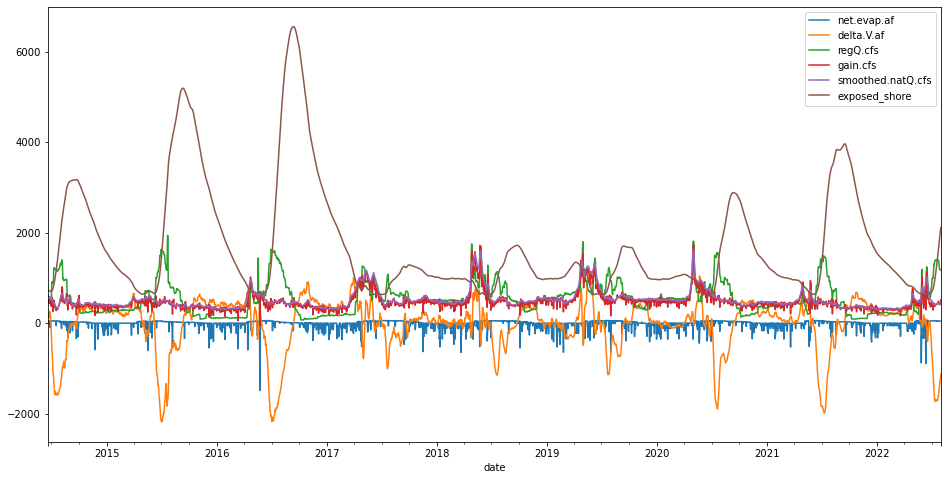

In [69]:
hydro_interp.plot(figsize=(16,8))

In [24]:
climate_df = pd.read_csv('data/Clean.Climate.TS.csv')
climate_df['Date'] = pd.to_datetime(climate_df['Date'])
climate_df.set_index(['Date'], inplace=True)
climate_df.drop(['GT.TAVE', 'GT.TMIN', 'GT.TMAX', 'GT.DP', 'GT.AP', 'GT.SWE', 'PB.TAVE',
       'PB.TMIN', 'PB.TMAX', 'PB.DP','HFW.AP', 'TR.SWE', 'FR.SWE', 'HF.SWE', 'HFW.SWE', 'AG.DP', 'AG.ET',
       'HFW.Cum.P', 'AG.Cum.P', 'AG.Cum.ET', 'PB.AP', 'PB.SWE', 'BB.TAVE', 'BB.TMIN', 'BB.TMAX', 'BB.DP', 'BB.AP',
       'BB.SWE', 'LL.TAVE', 'LL.TMIN', 'LL.TMAX', 'LL.DP', 'LL.AP', 'LL.SWE', 'GL.TAVE',
       'GL.TMIN', 'GL.TMAX', 'GL.DP', 'GL.AP', 'GL.SWE', 'PC.TAVE', 'PC.TMIN', 'PC.TMAX',
       'PC.DP', 'PC.AP', 'PC.SWE', 'AL.TAVE', 'AL.TMIN', 'AL.TMAX', 'AL.DP', 'AL.AP',
       'AS.TAVE', 'AS.TMIN', 'AS.TMAX', 'AS.DP', 'AS.AP', 'AS.ET', 'RX.TAVE',
       'RX.TMIN', 'RX.TMAX', 'RX.DP', 'RX.AP', 'RX.ET', 'TR.TAVE', 'FR.TAVE',
       'HF.TAVE', 'VA.TAVE', 'HFW.TAVE', 'TR.TMIN', 'FR.TMIN', 'HF.TMIN',
       'VA.TMIN', 'HFW.TMIN', 'TR.TMAX', 'FR.TMAX', 'HF.TMAX', 'VA.TMAX',
       'HFW.TMAX', 'TR.DP', 'FR.DP', 'HF.DP', 'VA.DP', 'HFW.DP', 'TR.AP',
       'FR.AP', 'HF.AP', 'VA.AP'], axis=1, inplace=True)
climate_df.index.names = ['date']
climate_df.columns

Index(['WE.TAVE', 'WE.TMIN', 'WE.TMAX', 'WE.DP', 'WE.AP', 'WE.SWE', 'CC.TAVE',
       'CC.TMIN', 'CC.TMAX', 'CC.DP', 'CC.AP', 'CC.SWE', 'IP.TAVE', 'IP.TMIN',
       'IP.TMAX', 'IP.DP', 'IP.AP', 'IP.SWE'],
      dtype='object')

In [25]:
climate_df = climate_df['2014-06-20':'2022-08-01']

In [26]:
clim_interp = climate_df.interpolate(method='spline', order=2)

In [27]:
clim_interp.isna().sum()

WE.TAVE    0
WE.TMIN    0
WE.TMAX    0
WE.DP      0
WE.AP      0
WE.SWE     0
CC.TAVE    0
CC.TMIN    0
CC.TMAX    0
CC.DP      0
CC.AP      0
CC.SWE     0
IP.TAVE    0
IP.TMIN    0
IP.TMAX    0
IP.DP      0
IP.AP      0
IP.SWE     0
dtype: int64

<AxesSubplot:xlabel='date'>

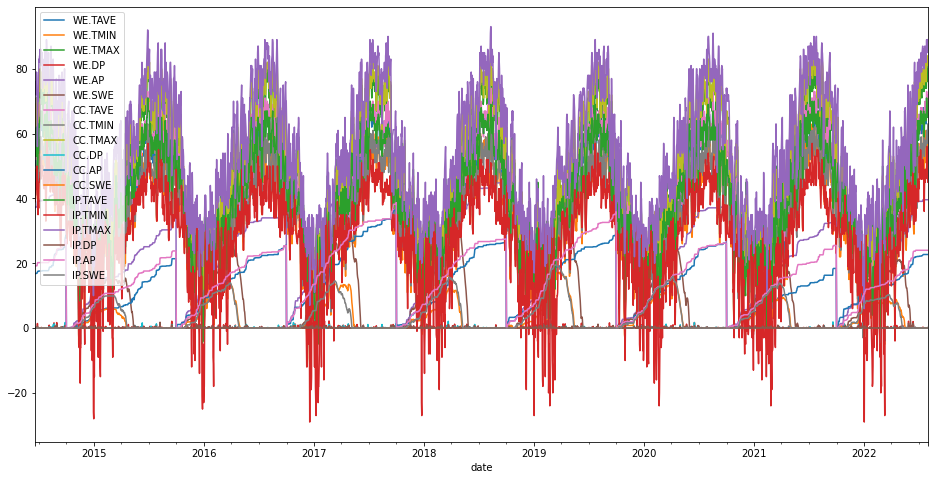

In [28]:
clim_interp.plot(figsize=(16,8))

In [29]:
clim_interp

,WE.TAVE,WE.TMIN,WE.TMAX,WE.DP,WE.AP,WE.SWE,CC.TAVE,CC.TMIN,CC.TMAX,CC.DP,CC.AP,CC.SWE,IP.TAVE,IP.TMIN,IP.TMAX,IP.DP,IP.AP,IP.SWE
date,,,,,,,,,,,,,,,,,,
2014-06-20,56.0,46.0,67.0,0.0,37.2,0.0,58.0,46.0,69.0,0.1,16.8,0.0,58.0,39.0,75.0,0.0,19.2,0.0
2014-06-21,55.0,49.0,62.0,0.0,37.2,0.0,58.0,48.0,68.0,0.0,16.8,0.0,58.0,42.0,76.0,0.0,19.2,0.0
2014-06-22,50.0,43.0,57.0,0.2,37.4,0.0,52.0,46.0,62.0,0.0,16.8,0.0,53.0,45.0,72.0,0.0,19.2,0.0
2014-06-23,54.0,44.0,64.0,0.0,37.4,0.0,56.0,45.0,68.0,0.1,16.9,0.0,58.0,43.0,75.0,0.0,19.2,0.0
2014-06-24,58.0,47.0,71.0,0.0,37.4,0.0,60.0,51.0,71.0,0.0,16.9,0.0,62.0,47.0,79.0,0.0,19.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28,67.0,60.0,76.0,0.0,39.6,0.0,68.0,61.0,81.0,0.0,22.7,0.0,69.0,56.0,85.0,0.0,24.0,0.0
2022-07-29,66.0,56.0,78.0,0.0,39.6,0.0,67.0,57.0,83.0,0.0,22.7,0.0,66.0,52.0,86.0,0.0,24.0,0.0
2022-07-30,69.0,58.0,80.0,0.0,39.6,0.0,70.0,59.0,84.0,0.0,22.7,0.0,66.0,48.0,89.0,0.0,24.0,0.0


In [30]:
final_df = pd.merge(clim_interp, hydro_interp, on=['date'])

In [31]:
final_df.isna().sum()

WE.TAVE              0
WE.TMIN              0
WE.TMAX              0
WE.DP                0
WE.AP                0
WE.SWE               0
CC.TAVE              0
CC.TMIN              0
CC.TMAX              0
CC.DP                0
CC.AP                0
CC.SWE               0
IP.TAVE              0
IP.TMIN              0
IP.TMAX              0
IP.DP                0
IP.AP                0
IP.SWE               0
elevation.ft         0
volume.af            0
smoothed.vol         0
smoothed.elev        0
surfacearea.acres    0
net.evap.af          0
delta.V.af           0
regQ.cfs             0
gain.cfs             0
smoothed.natQ.cfs    0
exposed_shore        0
dtype: int64

In [33]:
final_df.head()

,WE.TAVE,WE.TMIN,WE.TMAX,WE.DP,WE.AP,WE.SWE,CC.TAVE,CC.TMIN,CC.TMAX,CC.DP,...,volume.af,smoothed.vol,smoothed.elev,surfacearea.acres,net.evap.af,delta.V.af,regQ.cfs,gain.cfs,smoothed.natQ.cfs,exposed_shore
date,,,,,,,,,,,,,,,,,,,,,
2014-06-20,56.0,46.0,67.0,0.0,37.2,0.0,58.0,46.0,69.0,0.1,...,130463.6,130508.842857,6302.415714,7270.598650,45.963939,157.885714,476.0,512.621037,591.405028,729.401350
2014-06-21,55.0,49.0,62.0,0.0,37.2,0.0,58.0,48.0,68.0,0.0,...,130621.9,130700.671429,6302.440000,7273.992421,47.815575,191.828571,459.0,513.032397,599.594050,726.007579
2014-06-22,50.0,43.0,57.0,0.2,37.4,0.0,52.0,46.0,62.0,0.0,...,131097.5,130858.485714,6302.460000,7277.366317,45.131249,157.814286,449.0,483.831078,601.354315,722.633683
2014-06-23,54.0,44.0,64.0,0.0,37.4,0.0,56.0,45.0,68.0,0.1,...,130857.6,130971.200000,6302.474286,7279.964667,49.711959,112.714286,459.0,473.033457,586.847675,720.035333
2014-06-24,58.0,47.0,71.0,0.0,37.4,0.0,60.0,51.0,71.0,0.0,...,131252.6,131209.542857,6302.504286,7283.303116,50.669190,238.342857,448.0,525.632347,582.186314,716.696884


<AxesSubplot:xlabel='date'>

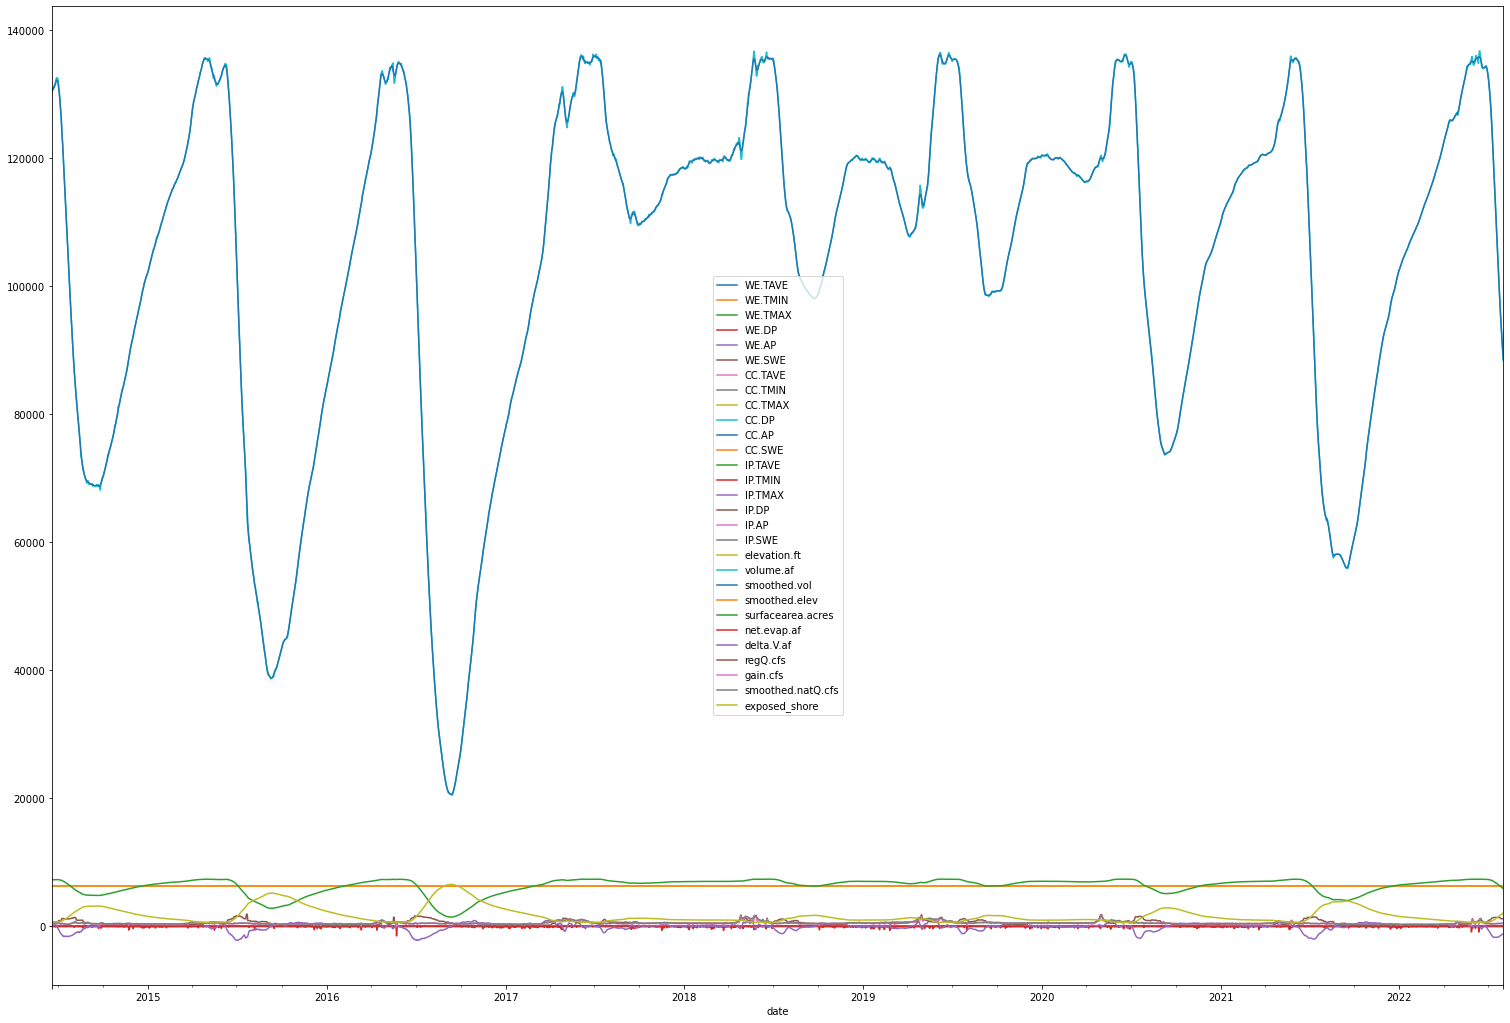

In [34]:
final_df.plot(figsize=(26,18))

In [37]:
ipe_turbid = pd.read_csv("data/daily_mean_data_HFF/IPE Turbidity Daily Mean IY 2022-08-10.csv")
ipe_turbid.drop(['Year.count','Min','Median','Max','Q1','Q3','StDev'], axis=1, inplace=True)
ipe_turbid.set_index(['X'], inplace=True)
ipe_turbid

,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022,Mean
X,,,,,,,,,,
01-Nov,NaN,NaN,3.208105,2.949688,2.876667,3.249149,4.347083,3.024211,5.588842,3.275817
02-Nov,NaN,NaN,3.243263,2.991250,2.873750,2.263295,4.526947,2.809792,5.366809,3.118050
03-Nov,NaN,NaN,3.025521,2.599579,2.746146,0.830968,5.030737,2.810426,6.291458,2.840563
04-Nov,NaN,NaN,2.917579,2.313958,2.837188,1.320581,5.095368,2.880105,6.521522,2.894130
05-Nov,NaN,NaN,2.910833,2.347604,2.915417,0.617826,5.108229,2.921875,6.538022,2.803631
...,...,...,...,...,...,...,...,...,...,...
27-Oct,NaN,3.373333,3.925319,2.432211,5.790526,3.073125,3.604526,6.443441,NaN,4.091783
28-Oct,NaN,3.300729,3.820833,2.681702,4.629579,3.516354,3.448280,5.313763,NaN,3.815891
29-Oct,NaN,3.469158,3.605000,2.871875,4.562660,4.033085,3.291809,5.361170,NaN,3.884965


<AxesSubplot:xlabel='X'>

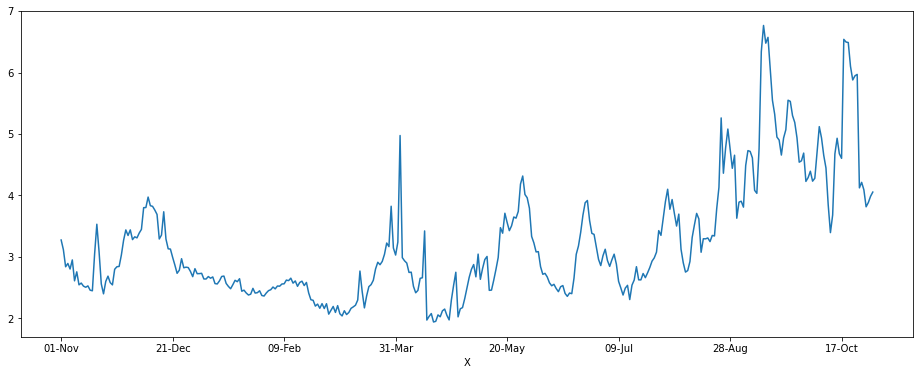

In [38]:
ipe_turbid['Mean'].plot(figsize=(16,6))

In [39]:
data_transform = pd.Series(np.log(ipe_turbid['Mean']))
rolmean = data_transform.rolling(window=4, center=False).mean()
data_minus_rolmean = data_transform - rolmean

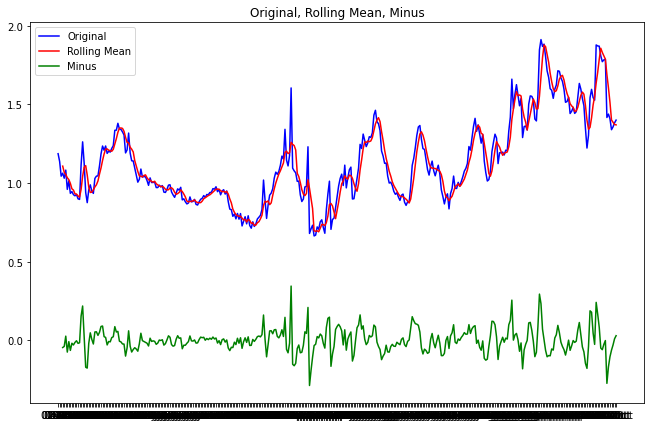

In [40]:
fig = plt.figure(figsize=(11, 7))
orig = plt.plot(data_transform, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
minus = plt.plot(data_minus_rolmean, color='green', label='Minus')
plt.legend(loc='best')
plt.title('Original, Rolling Mean, Minus')
plt.show(block=False)

In [41]:
diff = data_transform.diff().dropna()
dftest = adfuller(diff)
display_df(dftest)

Test Statistic                  -5.383212
p-value                          0.000004
#Lags Used                      16.000000
Number of Observations Used    347.000000
Critical Value (1%)             -3.449337
Critical Value (5%)             -2.869906
Critical Value (10%)            -2.571227
dtype: float64

<AxesSubplot:xlabel='X'>

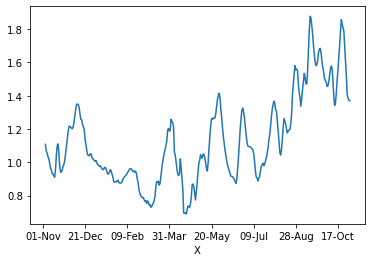

In [42]:
rolmean.plot()

In [43]:
ipe_chloro = pd.read_csv('data/daily_mean_data_HFF/IPE Chloro Daily Mean IY 2022-08-10.csv')
ipe_chloro.drop(['Year.count'], axis=1, inplace=True)
ipe_chloro.set_index(['X'], inplace=True)
ipe_chloro

,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022,Min,Q1,Median,Mean,Q3,Max,StDev
X,,,,,,,,,,,,,,,,
01-Nov,NaN,NaN,2.356667,2.386563,4.092838,2.022386,11.270350,1.785934,1.760737,1.785934,2.105956,2.371615,3.985790,3.666269,11.270350,3.660114
02-Nov,NaN,NaN,2.716092,2.848438,4.503600,2.661129,15.463440,1.851591,1.899451,1.851591,2.674870,2.782265,5.007382,4.089810,15.463440,5.195342
03-Nov,NaN,NaN,2.686742,3.163229,4.775526,2.610761,20.060360,1.985000,1.861522,1.985000,2.629756,2.924986,5.880270,4.372452,20.060360,7.010552
04-Nov,NaN,NaN,3.100000,3.595543,4.788987,3.131609,12.520500,2.282283,2.235882,2.282283,3.107902,3.363576,4.903154,4.490626,12.520500,3.821140
05-Nov,NaN,NaN,3.733000,3.743830,4.809079,4.087778,9.139118,2.434176,2.282674,2.434176,3.735708,3.915804,4.657830,4.628754,9.139118,2.326591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27-Oct,NaN,1.601702,1.971489,2.826914,0.867727,5.679706,1.339186,1.126630,NaN,0.867727,1.232908,1.601702,2.201908,2.399202,5.679706,1.662308
28-Oct,NaN,1.832022,2.439167,2.858171,0.986563,7.848113,1.724110,1.228587,NaN,0.986563,1.476348,1.832022,2.702390,2.648669,7.848113,2.359476
29-Oct,NaN,2.125506,2.274271,2.307416,1.058495,9.245000,2.066757,1.150737,NaN,1.058495,1.608747,2.125506,2.889740,2.290843,9.245000,2.850327


<AxesSubplot:xlabel='X'>

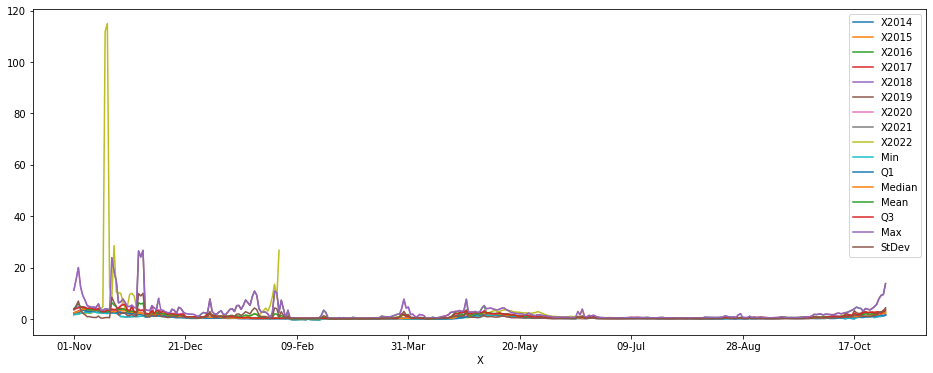

In [44]:
ipe_chloro.plot(figsize=(16,6))

In [45]:
ipe_cond = pd.read_csv('data/daily_mean_data_HFF/IPE Cond Daily Mean IY 2022-08-10.csv')
ipe_cond.drop(['Year.count'], axis=1, inplace=True)
ipe_cond.set_index(['X'], inplace=True)
ipe_cond

,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022,Min,Q1,Median,Mean,Q3,Max,StDev
X,,,,,,,,,,,,,,,,
01-Nov,NaN,95.90947,110.4885,128.5469,110.1702,133.9132,107.8240,120.752600,117.303125,95.90947,108.997100,110.488500,115.372124,124.649750,133.9132,13.121068
02-Nov,NaN,95.06737,109.6737,126.9781,109.6937,129.6117,107.8737,120.002100,117.422105,95.06737,108.773700,109.693700,114.128624,123.490100,129.6117,12.119563
03-Nov,NaN,97.82917,108.3333,122.6167,109.4708,122.9365,108.0589,119.557300,116.756250,97.82917,108.196100,109.470800,112.686096,121.087000,122.9365,9.330285
04-Nov,NaN,100.18330,110.2240,119.1875,108.8031,120.3387,108.2937,119.392700,116.540860,100.18330,108.548400,110.224000,112.346143,119.290100,120.3387,7.547105
05-Nov,NaN,100.40830,111.3865,117.7531,107.9042,118.1874,108.3240,119.178100,117.761538,100.40830,108.114100,111.386500,111.877371,117.970250,119.1781,6.926211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27-Oct,104.8042,114.29580,124.3208,112.6427,137.2474,111.4885,122.1379,116.155914,NaN,104.80420,112.354150,115.225857,117.886652,122.683625,137.2474,9.926771
28-Oct,104.7094,114.08750,125.9542,113.4562,136.3500,110.8604,121.6183,117.332258,NaN,104.70940,112.807250,115.709879,118.046032,122.702275,136.3500,9.834927
29-Oct,103.9750,113.71350,126.0333,113.4552,136.3094,105.5104,121.2684,118.594737,NaN,103.97500,111.469000,116.154118,117.357492,122.459625,136.3094,10.685248


<AxesSubplot:xlabel='X'>

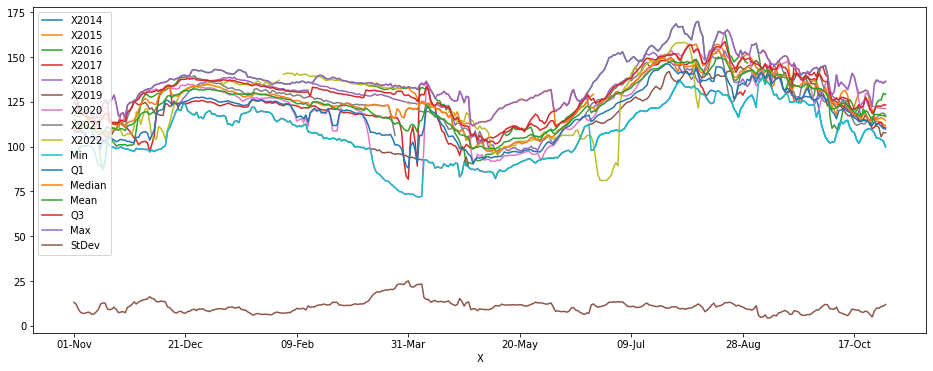

In [46]:
ipe_cond.plot(figsize=(16,6))

In [47]:
ipe_odo = pd.read_csv('data/daily_mean_data_HFF/IPE ODO Daily Mean IY 2022-08-10.csv')
ipe_odo.drop(['Year.count','Min','Median','Max','Q1','Q3','StDev'], axis=1, inplace=True)
ipe_odo.set_index(['X'], inplace=True)
ipe_odo

,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022,Mean
X,,,,,,,,,,
01-Nov,NaN,8.533789,10.006670,7.606146,9.435532,9.242418,10.664170,9.005684,9.139167,9.213487
02-Nov,NaN,8.870526,10.022530,7.763542,9.339063,9.301915,10.824530,9.085000,9.111158,9.315301
03-Nov,NaN,8.718958,10.048440,7.929167,9.308750,9.707083,10.878000,9.173646,9.124792,9.394863
04-Nov,NaN,8.891979,10.180730,8.027917,9.355208,9.788817,10.906740,9.261250,9.228280,9.487520
05-Nov,NaN,9.340729,10.301150,8.055729,9.469583,9.403684,11.079380,9.343854,9.212088,9.570587
...,...,...,...,...,...,...,...,...,...,...
27-Oct,8.004792,9.839688,7.745417,8.990312,9.270737,10.344480,8.546316,8.800753,NaN,8.942812
28-Oct,8.304375,9.904271,7.493542,8.534583,9.370521,10.171460,8.556774,8.972258,NaN,8.913473
29-Oct,8.436042,9.816458,7.601354,8.368542,9.258333,10.456670,8.617263,8.956000,NaN,8.938833


<AxesSubplot:xlabel='X'>

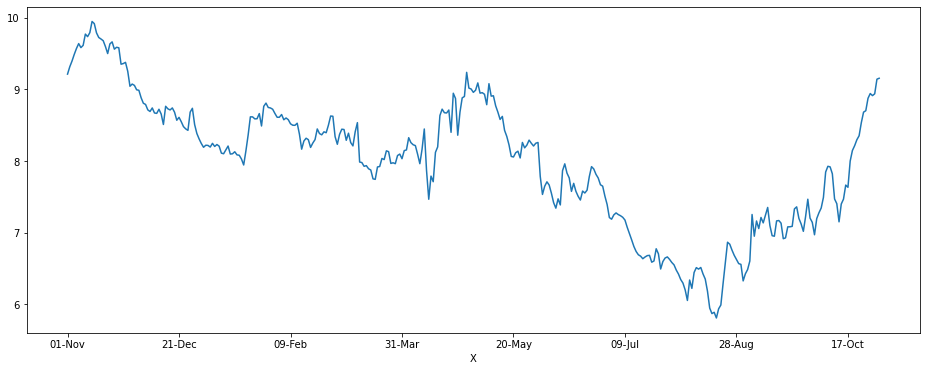

In [48]:
ipe_odo['Mean'].plot(figsize=(16,6))

In [49]:
ipe_temp = pd.read_csv("data/daily_mean_data_HFF/IPE Temp_C Daily Mean IY 2022-08-10.csv")
ipe_temp

,X,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022,Min,Q1,Median,Mean,Q3,Max,StDev,Year.count
0,01-Nov,NaN,7.453442,7.898646,7.429729,5.933255,6.539264,3.773323,5.605284,7.106448,3.773323,5.769270,6.539264,6.376135,7.441586,7.898646,1.424797,7
1,02-Nov,NaN,7.646242,7.547926,7.450990,5.761427,6.645404,3.823053,5.524563,7.179147,3.823053,5.642995,6.645404,6.342801,7.499458,7.646242,1.404017,7
2,03-Nov,NaN,7.326146,7.116865,7.362844,5.679490,6.617687,3.900253,5.504823,7.100490,3.900253,5.592156,6.617687,6.215444,7.221506,7.362844,1.269966,7
3,04-Nov,NaN,7.345667,7.222812,7.249729,5.509135,6.382957,3.933084,5.439021,7.061763,3.933084,5.474078,6.382957,6.154629,7.236270,7.345667,1.269841,7
4,05-Nov,NaN,7.281333,7.183896,7.125896,5.266781,6.215853,3.982396,5.378979,6.987198,3.982396,5.322880,6.215853,6.062162,7.154896,7.281333,1.246636,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27-Oct,8.886104,9.060667,7.440260,6.615135,6.403621,5.015500,6.117116,7.803828,NaN,5.015500,6.331995,7.027698,7.167779,8.074397,9.060667,1.395913,8
361,28-Oct,8.667104,9.020854,7.432146,6.567833,6.487563,4.858271,5.951226,7.764376,NaN,4.858271,6.353479,6.999989,7.093672,7.990058,9.020854,1.398990,8
362,29-Oct,8.511771,8.923000,7.408333,6.472104,6.431740,3.641906,5.851695,7.698021,NaN,3.641906,6.286729,6.940219,6.867321,7.901459,8.923000,1.677307,8
363,30-Oct,8.279510,8.638146,7.488521,6.123677,6.473737,3.819000,5.800750,7.637874,NaN,3.819000,6.042945,6.981129,6.782652,7.798283,8.638146,1.567078,8


<AxesSubplot:>

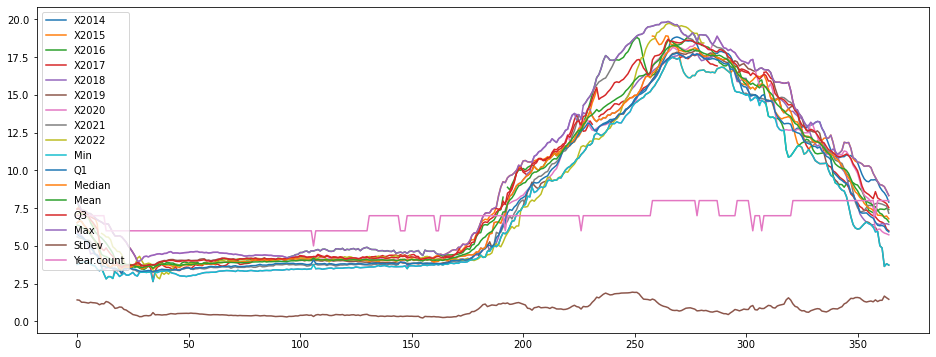

In [50]:
ipe_temp.plot(figsize=(16,6))

In [51]:
ipe_bga = pd.read_csv('data/daily_mean_data_HFF/IPE BGA Daily Mean IY 2022-08-10.csv')
ipe_bga

,X,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022,Min,Q1,Median,Mean,Q3,Max,StDev,Year.count
0,01-Nov,NaN,NaN,0.590938,0.568125,0.830106,0.495000,3.677949,0.188947,0.613021,0.188947,0.513281,0.579531,1.058511,0.770314,3.677949,1.299724,6
1,02-Nov,NaN,NaN,0.572842,0.644687,0.858437,0.860422,5.970725,0.192083,0.649362,0.192083,0.590803,0.751563,1.516533,0.859926,5.970725,2.195825,6
2,03-Nov,NaN,NaN,0.602604,0.735313,0.869687,0.668632,7.273281,0.199792,0.541771,0.199792,0.619111,0.701972,1.724885,0.836094,7.273281,2.727505,6
3,04-Nov,NaN,NaN,0.696354,0.809792,0.934063,0.719032,5.221831,0.225729,0.689677,0.225729,0.702024,0.764412,1.434467,0.902995,5.221831,1.870960,6
4,05-Nov,NaN,NaN,0.849688,0.872812,0.880313,0.975914,3.508235,0.256250,0.699780,0.256250,0.855469,0.876563,1.223869,0.952014,3.508235,1.148684,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27-Oct,NaN,0.305625,0.490417,0.684516,0.239341,1.700208,0.154211,0.489462,NaN,0.154211,0.272483,0.489462,0.580540,0.587466,1.700208,0.525141,7
361,28-Oct,NaN,0.371250,0.536042,0.597979,0.214271,2.296154,0.267753,0.512935,NaN,0.214271,0.319501,0.512935,0.685198,0.567010,2.296154,0.724489,7
362,29-Oct,NaN,0.450208,0.526354,0.548958,0.230860,3.303111,0.285591,0.437263,NaN,0.230860,0.361427,0.450208,0.826050,0.537656,3.303111,1.098574,7
363,30-Oct,NaN,0.525312,0.507083,1.032083,0.277790,3.241071,0.206210,0.434316,NaN,0.206210,0.356053,0.507083,0.889124,0.778698,3.241071,1.070620,7


<AxesSubplot:>

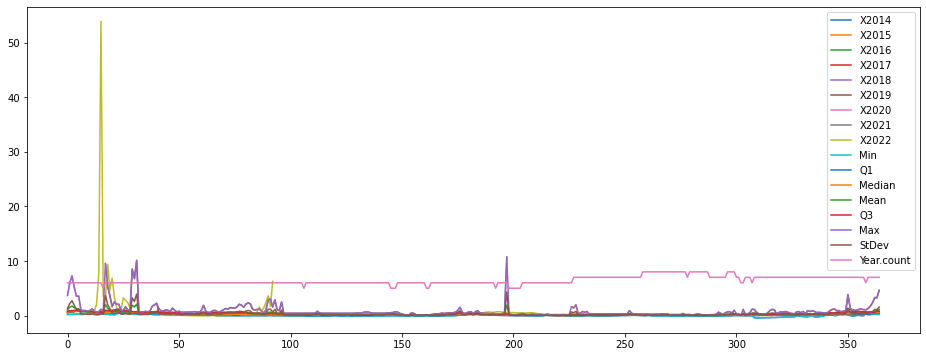

In [52]:
ipe_bga.plot(figsize=(16,6))